  Fase 1: Importar librerias

In [132]:
#from google.colab import drive
#drive.mount('/content/drive')


In [1]:
import astropy
import numpy as np
import scipy
import numpy
#!pip install pyspeckit #una vez usado comentar esta linea de codigo
import pyspeckit
#import sedfitter
import zipfile
import os
import re
#from astropy.extern import six
#from sedfitter.filter import Filter
#from sedfitter import fit
import matplotlib.pyplot as plt
#from sklearn import preprocessing
from astropy.table import QTable,Table,Column
from astropy.io import ascii
from sklearn.metrics import auc

Fase 2: Funciones


In [2]:
def Filterdat(lista): #filtrar datos de directorios por ".dat"
    return [name for name in lista if re.search(r'dat', name)]

def colxfil(mat): #en una tabla, o matriz, cambiar filas por columnas
    num=[i for i in range(len(mat[0]))]
    aux=[]
    mat2=[]
    for pos in num:
        aux=[]
        for lista in mat:
            aux.append(lista[pos])
        
        mat2.append(aux)
    return mat2

#def norm(lista): #normalizacion de datos por preprocessing
#    return preprocessing.normalize(lista)

def norm(lista): #normalización de datos por maximos y minimos
    a=[]
    for f in lista:
        a.append((f-min(lista))/(max(lista)-min(lista)))
    return a


def unique(lista): #devuelve una lista con datos unicos, los repetidos fuera
    unicos=[]
    for i in lista:
        if i not in unicos:
            unicos.append(i)
    return unicos

def recta(punto1,punto2,evaluar): #crea valores entre 2 puntos en funcion de un conjunto externo
    x1=punto1[0]
    y1=punto1[1]
    x2=punto2[0]
    y2=punto2[1]
    if x2!=x1:
        m=(y2-y1)/(x2-x1)
    if x2==x1:
        pass
    c=y1-(m*x1)
    return [(m*x)+c for x in evaluar]
    

def integrar(datos_entrada,datos_respuesta,limite_minimo,limite_maximo,cantidad_sumas): #terminado y por probar en datos reales

    delta=(limite_maximo-limite_minimo)
    divisiones=float(delta/cantidad_sumas)
    
    
    dominio_1=float(limite_minimo)
    dominio=[dominio_1]
    aprox=len(str(cantidad_sumas))
    while round(float(dominio_1),aprox)!=round(float(limite_maximo),aprox): #funciona generando las divisiones de base n, guardado en la lista dominio.
        dominio_1+=divisiones
        dominio.append(round(dominio_1,aprox))
    #return dominio
    
    coordenadas=[]
    for ejex,ejey in zip(datos_entrada,datos_respuesta): #guarda los conjuntos de coordendas que entran.
        if ejex >= min(dominio) and ejex <= max(dominio):
            for value in dominio:
                if round(float(value))==float(ejex):
                    coordenadas.append([ejex,ejey])
    #return unique(coordenadas)
    
    coordenadas2=unique(coordenadas)
    #indices=0
    
    valores=[]
    dom=[]
    respuestas=[]
    
    for contador in range(0,len(coordenadas2)-1): #correctamente se separan las rectas, y todos los valores en x tienen respuesta en el eje y.
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas2[contador],coordenadas2[contador+1]]
            if valores>=coordenadas2[contador][0] and valores <=coordenadas2[contador+1][0]:
                datos_x.append(valores)
                
        dom.append(datos_x)
        aux=recta(puntos[0],puntos[1],datos_x)
        respuestas.append(aux)    
    #return (dom,respuestas)
    salida=[]
    for recta_x,recta_y in zip(dom,respuestas): #salida correcta.
        c=0
        aux=[]
        while c!=(len(recta_x)-1):
            base=recta_x[c+1]-recta_x[c]
            altura=recta_y[c] ###revisar si el modelo creado sirve y para cual respuesta #c+1, acercamiento superior; c, acercamiento innferior.
            aux.append(base*altura)
            c+=1
        salida.append(aux)
    #return salida
    
    integrado=0
    for lista in salida: #sumatoria final; integración.
        integrado+=sum(lista)
    return integrado
  
def magnitude(lum):
    Lsun=3.828*(10**33)
    M_abs_sun=4.83
    L_L=np.log10(lum/Lsun)
    
    return M_abs_sun-((2.5)*(L_L))

In [3]:
def convolution(espectro,filtro,cantidad_sumas): #ingresan 2 tablas de 2 columnas y m,n filas cada uno, m y n pueden ser iguales o no
    spectra_wl=[]
    spectra_flux=[]
    
    for pair in espectro:
        spectra_wl.append(pair[0])
        spectra_flux.append(pair[1])
        
    filter_wl=[]
    filter_flux=[]
    filter_mixto=[]
    for pair in filtro:
        filter_wl.append(pair[0])
        filter_flux.append(pair[1])
        filter_mixto.append([pair[0],pair[1]])
        
    limite_maximo=max(filter_wl)
    limite_minimo=min(filter_wl)
    
    delta=(limite_maximo-limite_minimo)
    divisiones=float(delta/cantidad_sumas)
    
    
    
    apr=sorted(filter_flux)[1]
    contador=0
    while apr<1000:  #contador de aproximación en base al minimo superior a 0 de los datos del filtro.
        contador+=1
        apr=apr*10
    #return contador
    
    #return apr
    ##########################
    #mismo dominio para ambos#
    ##########################
    dominio_1=float(limite_minimo)
    dominio=[dominio_1]
    aprox=contador
    while round(float(dominio_1),aprox)!=round(float(limite_maximo),aprox): #funciona generando las divisiones de base n, guardado en la lista dominio.
        dominio_1+=divisiones
        dominio.append(round(dominio_1,aprox))

    #return (dominio) #checked#

    #################
    #spectral coords#
    #################
    m=[]
    coords_spectra=[]
    for ejex,ejey in zip(spectra_wl,spectra_flux): #guarda los conjuntos de coordendas que entran.
        if ejex >= min(dominio) and ejex <= max(dominio):
            m.append(ejex)
            for value in dominio:
                if round(float(value),aprox)==round(float(ejex),aprox):
                    coords_spectra.append([ejex,ejey])
    #return [m,dominio]
    coordenadas2=unique(coords_spectra)
    spectra_limitada_wl=[pair[0] for pair in coordenadas2]
    spectra_limitada_flux=[pair[1] for pair in coordenadas2]
    
    #return coordenadas2
    
    ###############
    #filtro coords#
    ###############
    coords_filtro=[]
    for ejex,ejey in zip(filter_wl,filter_flux):
        for value in dominio:
            if round(float(value),aprox)==round(float(ejex),aprox):
                coords_filtro.append([ejex,ejey])
                
    coordenadas3=unique(coords_filtro)
    filtro_limitada_wl=[pair[0] for pair in coordenadas3]
    filtro_limitada_flux=[pair[1] for pair in coordenadas3]

    #return [coordenadas2,coordenadas3]

    ####################
    #espectro respuesta#
    ####################
    S_wl=[]
    S_respuestas=[]
    for contador in range(0,len(coordenadas2)-1): #correctamente se separan las rectas, y todos los valores en x tienen respuesta en el eje y.
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas2[contador],coordenadas2[contador+1]]
            if valores>=coordenadas2[contador][0] and valores <=coordenadas2[contador+1][0]:
                datos_x.append(valores)   
        S_wl.append(datos_x)
        aux=recta(puntos[0],puntos[1],datos_x)
        S_respuestas.append(aux)
     
    Swl_cont=[]
    SR_cont=[]
    for wl in S_wl:
        Swl_cont+=wl
    for rfl in S_respuestas:
        SR_cont+=rfl
        
       
    #return dominio
    ##################
    #filtro respuesta#
    ##################
    m=[]
    F_wl=[]
    F_respuestas=[]
    for contador in range(0,len(coordenadas3)-1):
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas3[contador],coordenadas3[contador+1]]
            m.append([valores,puntos])
            if valores >= puntos[0][0] and valores <= puntos[1][0]:
                datos_x.append(valores)
        F_wl.append(datos_x)
        aux2=recta(puntos[0],puntos[1],datos_x)
        F_respuestas.append(aux2)
    
    Fwl_cont=[]
    FR_cont=[]
    for wl in F_wl:
        Fwl_cont+=wl
    for rfl in F_respuestas:
        FR_cont+=rfl
    
    #return [coordenadas2,coordenadas3]

    ###############################################################
    #ver el minimo en el flujo para cada valor de longitud de onda#
    ###############################################################
    espectro_final=[]
    for s,f in zip(SR_cont,FR_cont):
        aux=min(s,f)
        espectro_final.append(aux)
    #return [Swl_cont,FR_cont,espectro_final]


    convol=[]
    c=0
    aux=[]
    while c!=(len(Swl_cont)-1):
        base=Swl_cont[c+1]-Swl_cont[c]
        altura=espectro_final[c] ###revisar si el modelo creado sirve y para cual respuesta #c+1, acercamiento superior; c, acercamiento innferior.
        convol.append(base*altura)
        c+=1
    convolucion=sum(convol)
    return convolucion

In [4]:
'''
print(os.listdir('drive/MyDrive/Taller_de_investigación'))
HUB='drive/MyDrive/Taller_de_investigación' #usar como base para ir a los filtros o los espectros
'''

"\nprint(os.listdir('drive/MyDrive/Taller_de_investigación'))\nHUB='drive/MyDrive/Taller_de_investigación' #usar como base para ir a los filtros o los espectros\n"

Fase 3: Filtros (datos y normalización)

In [5]:
filtros=os.listdir(f'splus_filters-master')
Filtros=(Filterdat(filtros))
paths=[f'splus_filters-master/'+name for name in Filtros]
#Filtros

In [6]:
#identification of each filter
Tablas_general_filtros=[]
for value in paths:
    auxiliar1=(astropy.io.ascii.read(value))
    Tablas_general_filtros.append(auxiliar1) #12 tablas con datos de los filtros, col1: longitud de onda / col2: flujo
len(Tablas_general_filtros)

12

In [7]:
#graficando filtros
'''
colors=['red','green','blue','cyan','magenta','brown','yellow','black','lightblue','pink','aquamarine','violet']
pedido=''
while pedido!='YES' and pedido!='NO':
    try:
        pedido=str(input('Requires legend? >')).upper()
  
    except(ValueError):
        print('Formato incorrecto')
    
for color,fil in zip(colors,Filtros):
    #print(color)
    xau=colors.index(color)
    plt.plot(np.log10(Tablas_general_filtros[xau]['col1']),Tablas_general_filtros[xau]['col2'],color)
    if pedido=='YES':
        plt.legend(Filtros)
    #print(xau)
    
    plt.title('SPLUS Filters')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux?')
plt.show()
'''

"\ncolors=['red','green','blue','cyan','magenta','brown','yellow','black','lightblue','pink','aquamarine','violet']\npedido=''\nwhile pedido!='YES' and pedido!='NO':\n    try:\n        pedido=str(input('Requires legend? >')).upper()\n  \n    except(ValueError):\n        print('Formato incorrecto')\n    \nfor color,fil in zip(colors,Filtros):\n    #print(color)\n    xau=colors.index(color)\n    plt.plot(np.log10(Tablas_general_filtros[xau]['col1']),Tablas_general_filtros[xau]['col2'],color)\n    if pedido=='YES':\n        plt.legend(Filtros)\n    #print(xau)\n    \n    plt.title('SPLUS Filters')\n    plt.xlabel('Wavelength [A]')\n    plt.ylabel('Flux?')\nplt.show()\n"

In [8]:
#Tabla continua/ Datos de filtros como una unica tabla
Tabla_continua=Table()
wave=[]
flux=[]
for table in Tablas_general_filtros:
    for value in table['col1']:
        wave.append(value)
    for value in table['col2']:
        flux.append(value)

Tabla_continua['Wavelength']=wave
Tabla_continua['Flux']=flux
#Tabla_continua #tabla de datos mixtos de todos los filtros


In [9]:
#normalizar filtros
Tabla_continua_normalizada=Table()
maxi=max(Tabla_continua['Flux'])
mini=min(Tabla_continua['Flux'])

LogW=[]
Nflux=[]

for value in Tabla_continua:
    auxiliar1=np.log10(value['Wavelength'])
    auxiliar2=(value['Flux']-mini)/(maxi-mini)
    LogW.append(auxiliar1)
    Nflux.append(auxiliar2)

Tabla_continua_normalizada['Log Wavelength']=LogW
Tabla_continua_normalizada['Normalized Flux']=Nflux

len(Tabla_continua_normalizada['Normalized Flux']) #tabla de datos mixtos, normalizada

1619

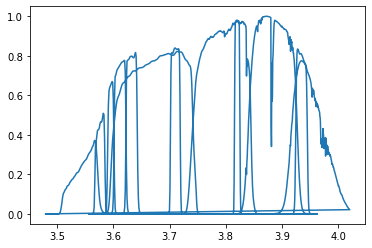

In [10]:
plt.plot(Tabla_continua_normalizada['Log Wavelength'],Tabla_continua_normalizada['Normalized Flux'])
plt.show()

In [11]:
#Separación normalizado
Tablas_para_filtros=[Table() for i in range(len(Tablas_general_filtros))]
contador=0
c=0
for par,tabla in zip(Tablas_general_filtros,Tablas_para_filtros):
    #print(len(par))
    contador=len(par)+c
    auxiliar_alpha=[]
    auxiliar_beta=[]
    for datos in Tabla_continua_normalizada[c:contador]:
        auxiliar_alpha.append(datos[0])
        auxiliar_beta.append(datos[1])
        c+=1
  
    tabla['Log Wavelength']=auxiliar_alpha
    tabla['Normalized Flux']=auxiliar_beta
#Tablas_para_filtros #contiene 12 tablas de los filtros bajo log y normalizados

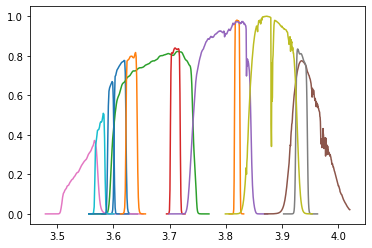

In [12]:
for tab in Tablas_para_filtros:
    plt.plot(tab['Log Wavelength'],tab['Normalized Flux'])
plt.show()

Fase 4: Espectros (data y normalización)

In [13]:
datos=os.listdir('SC2')
datos=sorted(datos[1:len(datos)])


search2=''
while search2 not in datos:
    print(f'The options are: ')
    for value in datos:
        print(f'{value}')
    search2=str(input('File name: >'))
    if search2 in datos:
        pass

aux0=sorted(os.listdir(f'SC2/{search2}'))
dts=[]
for value in aux0:
    if value=='.DS_Store':
        continue
    dts.append(value)


subdatos=dts

print(subdatos)
ind=[subdatos.index(i)+65 for i in subdatos]
ltr=[chr(number) for number in ind]
names=[f'{search2}{letra}' for letra in ltr]


search3=''
while search3 not in ltr:
    print('Options:')
    for value,lt in zip(names,ltr):
        print(f'for {value}, mark {lt}')
    try:
        search3=str(input('Which file would you want to open? >')).upper()
    except(ValueError):
        pass
    
ind2=ltr.index(search3)
topen=f'SC2/{search2}/{subdatos[ind2]}'

The options are: 
fig1
fig13
fig15
fig2
fig25
fig27
fig7
fig9
File name: >fig1
['fig1a.dat.txt', 'fig1b.dat.txt', 'fig1c.dat.txt', 'fig1d.dat.txt', 'fig1e.dat.txt']
Options:
for fig1A, mark A
for fig1B, mark B
for fig1C, mark C
for fig1D, mark D
for fig1E, mark E
Which file would you want to open? >a


In [14]:
alpha=[]
print(topen)
with open(topen,'r') as datos:
    line=datos.readlines()
    for linea in line:
        alpha.append(linea.split())
        
columns=(alpha[2][1:])
ages=columns[1:]

totaldatos=alpha[3:]
test001=colxfil(totaldatos)

wavelength=[(aux[0]) for aux in totaldatos]

por_longitud=[(aux[1:]) for aux in totaldatos] #usar este
por_edad=colxfil(por_longitud)
#print(por_longitud[0])
#print(por_edad[0])
por_edad

SC2/fig1/fig1a.dat.txt


[['21.766210',
  '22.247930',
  '22.708770',
  '22.981360',
  '23.291810',
  '23.672640',
  '23.943000',
  '24.204480',
  '24.501390',
  '24.870930',
  '25.327630',
  '25.781540',
  '26.181350',
  '26.551410',
  '26.787960',
  '26.919270',
  '27.115530',
  '27.298850',
  '27.433850',
  '27.669200',
  '27.947370',
  '28.234150',
  '28.526180',
  '28.817270',
  '29.113580',
  '29.353780',
  '29.571540',
  '29.823430',
  '30.074510',
  '30.247690',
  '30.437980',
  '30.620710',
  '30.689560',
  '30.921360',
  '31.155200',
  '31.294320',
  '31.498360',
  '31.634340',
  '31.774100',
  '31.996760',
  '32.208620',
  '32.342620',
  '32.454430',
  '32.593250',
  '35.163200',
  '35.630910',
  '35.755970',
  '35.898660',
  '36.130490',
  '36.289990',
  '36.368160',
  '36.981020',
  '37.107060',
  '37.185350',
  '37.021190',
  '37.394090',
  '37.572400',
  '37.508750',
  '37.896980',
  '38.277440',
  '38.309460',
  '38.444560',
  '38.509000',
  '38.517020',
  '38.864560',
  '39.215080',
  '39.1950

In [16]:
#tabla sin cambios
Tabla_datos=Table()
Tabla_datos['WL']=[np.log10(float(w)) for w in wavelength]
NE=norm([float(i) for i in edad])
for edad,name in zip(por_edad,ages):
    Tabla_datos[f'{name}']=[float(e) for e in NE]
Tabla_datos

TypeError: float() argument must be a string or a number, not 'list'

In [17]:
#Log y Normalizando el espectro
longitudes=[np.log10(float(val)) for val in wavelength]

por_longflout=[]

for lista in por_longitud:
    por_longflin=[]
    for value in lista:
        por_longflin.append((float(value)))
    por_longflout.append(por_longflin)

por_edadflout=[]

for lista in por_edad:
    por_edadflin=[]
    for value in lista:
        por_edadflin.append((float(value)))

    por_edadflout.append(por_edadflin)
Norm_spectra=[norm(edad) for edad in por_edadflout]


In [18]:
Tabla_espectro_final=Table()

Tabla_espectro_final['Log WL']=longitudes
for names,Nedad in zip(columns[1:],Norm_spectra):
    Tabla_espectro_final[f'{names}']=Nedad

In [19]:
Tabla_espectro_final #los dos anteriores cumplen con el mismo objetivo, los datos ahora son floats

Log WL,1Myr,2Myr,3Myr,4Myr,5Myr,6Myr,7Myr,8Myr,9Myr,10Myr,11Myr,12Myr,13Myr,14Myr,15Myr,16Myr,17Myr,18Myr,19Myr,20Myr,30Myr,40Myr,50Myr,60Myr,70Myr,80Myr,90Myr,100Myr,200Myr,300Myr,400Myr,500Myr,600Myr,700Myr,800Myr,900Myr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.9590413923210936,0.0,0.0,0.0,0.7064498909788385,0.6904302082955798,0.7781325236326739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9731278535996986,0.026544527601966503,0.02583450439827166,0.02714922671756532,0.7202308896307762,0.7014481798083243,0.7893730262677919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9822712330395684,0.05193849110792492,0.050601953419034805,0.05329737295205908,0.72996408182468,0.7093216112057473,0.7973826009317578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9912260756924949,0.0669591935471427,0.06519974890652103,0.06855672688092956,0.73857720598214,0.7163424614742059,0.8045166983390245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0840661199650423,0.08189259412099352,0.08621601455232895,0.7444598250232971,0.720848715174046,0.8090955833562035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0086001717619175,0.10505124087896929,0.10236011326779036,0.10778464498304817,0.7484497281256504,0.723725745016111,0.8120190520526814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.6020599913279625,0.7511761872906749,0.7858136779772085,0.8167266681762024,0.10894878267242075,0.10392342647868488,0.10469769978773164,0.8613821795219933,0.8865771311405181,0.8836341812559414,0.8809417825759888,0.8790507237508205,0.8769235482466442,0.8761279214420143,0.8744730079369644,0.8736966249986496,0.8723742770687812,0.8721613863620371,0.8719042826766842,0.871370638013576,0.8712977246107897,0.8686032690372866,0.8676411118005324,0.8674472789299288,0.867964733488757,0.8688346466791739,0.8697685503390382,0.8700745772862102,0.870220774575827,0.8741364424750605,0.8757296761426785,0.8769286987027356,0.8773297561315466,0.8772859000064729,0.8773254284856852,0.8793353056080778,0.8796291725821667
5.778151250383644,0.747980726949319,0.7831483372409678,0.8145231513633692,0.09845018049561664,0.09390128353154997,0.09453243608494898,0.8598274208565891,0.8848197693141765,0.8816282407424533,0.8786262821157599,0.8766626983685474,0.8739609511281022,0.872784403509411,0.8704800501944179,0.8697608431897061,0.8674603871835606,0.8670293113974582,0.8664771581113249,0.8648679181196335,0.8645281169860068,0.8584593823989362,0.8554950186946514,0.854484940071158,0.8547302992793299,0.8554373202835389,0.856317606246729,0.8565800853648591,0.8566986904240486,0.8604836231035713,0.8620405760733606,0.8632025053302731,0.863567285729382,0.8634942675566556,0.8635086066163529,0.8655074175389061,0.8657794591901015


In [31]:
len(Tablas_para_filtros)

12

In [102]:

Tabla_espectro_final

Log WL,1Myr,2Myr,3Myr,4Myr,5Myr,6Myr,7Myr,8Myr,9Myr,10Myr,11Myr,12Myr,13Myr,14Myr,15Myr,16Myr,17Myr,18Myr,19Myr,20Myr,30Myr,40Myr,50Myr,60Myr,70Myr,80Myr,90Myr,100Myr,200Myr,300Myr,400Myr,500Myr,600Myr,700Myr,800Myr,900Myr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.9590413923210936,0.0,0.0,0.0,0.7064498909788385,0.6904302082955798,0.7781325236326739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9731278535996986,0.026544527601966503,0.02583450439827166,0.02714922671756532,0.7202308896307762,0.7014481798083243,0.7893730262677919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9822712330395684,0.05193849110792492,0.050601953419034805,0.05329737295205908,0.72996408182468,0.7093216112057473,0.7973826009317578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9912260756924949,0.0669591935471427,0.06519974890652103,0.06855672688092956,0.73857720598214,0.7163424614742059,0.8045166983390245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0840661199650423,0.08189259412099352,0.08621601455232895,0.7444598250232971,0.720848715174046,0.8090955833562035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0086001717619175,0.10505124087896929,0.10236011326779036,0.10778464498304817,0.7484497281256504,0.723725745016111,0.8120190520526814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.6020599913279625,0.7511761872906749,0.7858136779772085,0.8167266681762024,0.10894878267242075,0.10392342647868488,0.10469769978773164,0.8613821795219933,0.8865771311405181,0.8836341812559414,0.8809417825759888,0.8790507237508205,0.8769235482466442,0.8761279214420143,0.8744730079369644,0.8736966249986496,0.8723742770687812,0.8721613863620371,0.8719042826766842,0.871370638013576,0.8712977246107897,0.8686032690372866,0.8676411118005324,0.8674472789299288,0.867964733488757,0.8688346466791739,0.8697685503390382,0.8700745772862102,0.870220774575827,0.8741364424750605,0.8757296761426785,0.8769286987027356,0.8773297561315466,0.8772859000064729,0.8773254284856852,0.8793353056080778,0.8796291725821667
5.778151250383644,0.747980726949319,0.7831483372409678,0.8145231513633692,0.09845018049561664,0.09390128353154997,0.09453243608494898,0.8598274208565891,0.8848197693141765,0.8816282407424533,0.8786262821157599,0.8766626983685474,0.8739609511281022,0.872784403509411,0.8704800501944179,0.8697608431897061,0.8674603871835606,0.8670293113974582,0.8664771581113249,0.8648679181196335,0.8645281169860068,0.8584593823989362,0.8554950186946514,0.854484940071158,0.8547302992793299,0.8554373202835389,0.856317606246729,0.8565800853648591,0.8566986904240486,0.8604836231035713,0.8620405760733606,0.8632025053302731,0.863567285729382,0.8634942675566556,0.8635086066163529,0.8655074175389061,0.8657794591901015


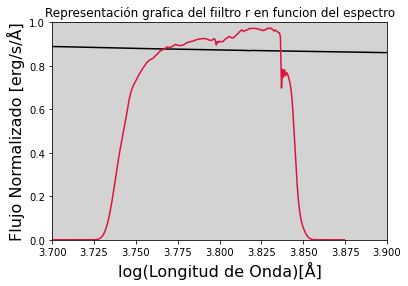

In [89]:
#normalizando los espectros
letra = "\033[1m" +'r' + "\033[0m"
ax = plt.axes()
ax.set_facecolor("lightgray")
plt.plot(Tabla_espectro_final['Log WL'],Tabla_espectro_final['1Myr'],color='k')

#for filt in Tablas_para_filtros:
    #plt.plot(filt['Log Wavelength'],filt['Normalized Flux'], color='r')
plt.plot(Tablas_para_filtros[4]['Log Wavelength'],Tablas_para_filtros[4]['Normalized Flux'],color='crimson')
plt.xlim(3.7,3.9)
plt.ylim(0,1)
plt.title(f'Representación grafica del fiiltro r en funcion del espectro')
plt.xlabel('log(Longitud de Onda)[Å]',fontsize = 16)
plt.ylabel('Flujo Normalizado [erg/s/Å]', fontsize = 16)

plt.savefig('Zoooooooooom.png',format='png')
plt.show()

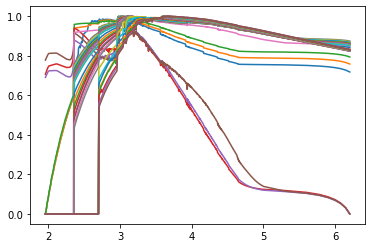

In [103]:
for name in zip(ages):
    plt.plot(Tabla_espectro_final['Log WL'],Tabla_espectro_final[name])
    
plt.show()


In [74]:
print("\033[1m" +'s' + "\033[0m")

s


In [21]:
Tablas_espectros_por_edad=[Table() for edad in range(len(columns[1:]))]
c=0

for table,name in zip(Tablas_espectros_por_edad,columns[1:]):
    if name!='[A]':
        table['Log WL']=Tabla_espectro_final['Log WL']
        table[f'{name}']=Tabla_espectro_final[name]
#Tablas_espectros_por_edad

In [159]:
#Filtros,columns

Cantidad_de_sumas=0
while Cantidad_de_sumas<=0:
    try:
        Cantidad_de_sumas=int(input('¿Cuantas sumas desea hacer? >'))
    except(ValueError):
        print('Valor debe ser un entero postivo')

Nombres_filtros=Filtros
Datos_por_filtro=Tablas_para_filtros
Nombres_edades=columns[1:]
Datos_por_edad=Tablas_espectros_por_edad

Valores_convolucion_por_filtro=[]


for Ename,Dedad in zip(Nombres_edades,Datos_por_edad):
    for Fname,Dfilter in zip(Nombres_filtros,Datos_por_filtro):
        crux=f'{Ename} en filtro {Fname}'
        guardar_convolucion=convolution(Dedad,Dfilter,Cantidad_de_sumas)
        Valores_convolucion_por_filtro.append([crux,guardar_convolucion])


¿Cuantas sumas desea hacer? >500


In [561]:
for lista in (Valores_convolucion_por_filtro):
    print(magnitude(lista[1][2]))
    #print(lista[0],':',lista[1][2])

93.26336213647184
93.33515652151495
92.79760362038654
93.27668879586216
92.79758174109413
92.79746354749602
92.79741481462304
92.79736514441788
92.79731000712518
93.26356489227477
93.2710290155637
93.26343247490355
93.26336213647184
93.33515652151495
92.79070328428155
93.27668879586216
92.79068703530798
92.79057251296305
92.79052703905272
92.79048082650455
92.79042919134714
93.26356489227477
93.2710290155637
93.26343247490355
93.26336213647184
93.33515652151495
92.78316824653255
93.27668879586216
92.7831574795563
92.78304675290255
92.78300408188495
92.78296094165104
92.7829126099718
93.26356489227477
93.2710290155637
93.26343247490355
93.27814676021995
93.35095921684008
92.88710030909581
93.29165727330555
92.88637976338667
92.88591561579317
92.88569013894296
92.88541879141177
92.88476427968259
93.27835229612428
93.28488351806742
93.27821806304274
93.2703316228171
93.34260408192405
92.87637838905862
93.28374463526526
92.87612246772918
92.87588034064125
92.87565684496104
92.8752067999579

In [203]:
#Tabla_espectro_final

In [523]:
tabula=Table()
TSP=Table()
alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_V-1.txt') as dt:
    data=dt.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))

TSP['[A]']=np.log10(alpha)
TSP['Tr']=[float(b) for b in bet]
tabula['[A]']=(np.log10(alpha))
tabula['Tr']=norm(beta)
tabula

[A],Tr
float64,float64
3.3010299956639813,0.00011625281245443908
3.302114376956201,0.00014228181918019285
3.303196057420489,0.00013711180489769947
3.3042750504771283,0.00013514744676118568
3.305351369446624,0.00013698188160789172
...,...
4.040404528914159,8.810393479985807e-05
4.040602340114073,4.869343470403882e-05
4.040800061256529,6.30013657914278e-05


In [526]:
tabula2=tabula[tabula['Tr']>0.025]

In [294]:
a=[]
b=[]
for value1 in tabula['[A]']:
    if value1>=200 and value1<=1100:
        a.append(value)
for value2 in Datos_por_edad[0]['Log WL']:
    b.append(value2)
max(b)

6.204119982655925

In [519]:
tabula

nm,Tr
float64,float64
3.3010299956639813,0.00011625281245443908
3.302114376956201,0.00014228181918019285
3.303196057420489,0.00013711180489769947
3.3042750504771283,0.00013514744676118568
3.305351369446624,0.00013698188160789172
...,...
4.040404528914159,8.810393479985807e-05
4.040602340114073,4.869343470403882e-05
4.040800061256529,6.30013657914278e-05


In [518]:
TED=[Table() for edad in range(len(columns[1:]))]
c=0

for table,name in zip(TED,ages):
    if name!='[A]':
        table['WL']=(Tabla_datos['WL'])
        table[f'{name}']=(Tabla_datos[name])


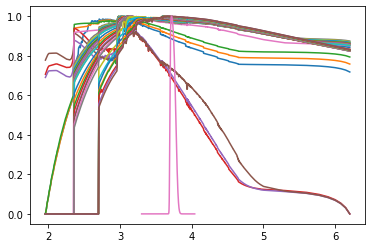

In [529]:
for Ename,Dedad in zip(Nombres_edades,Datos_por_edad):
    plt.plot(Dedad['Log WL'],Dedad[Ename])
plt.plot(tabula['[A]'],tabula['Tr'])
plt.show()

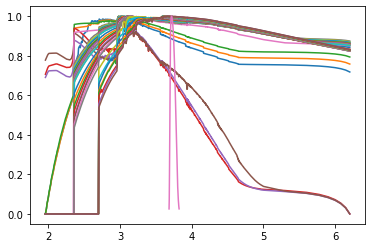

In [530]:
for Ename,Dedad in zip(Nombres_edades,Datos_por_edad):
    plt.plot(Dedad['Log WL'],Dedad[Ename])
plt.plot(tabula2['[A]'],tabula2['Tr'])
plt.show()

In [553]:
Cantidad_de_sumas=0
while Cantidad_de_sumas<=0:
    try:
        Cantidad_de_sumas=int(input('¿Cuantas sumas desea hacer? >'))
    except(ValueError):
        print('Valor debe ser un entero postivo')
gh=[]
for spectra in TED:

    gh.append(convolution(spectra,tabula2,Cantidad_de_sumas))

¿Cuantas sumas desea hacer? >1000


In [662]:
t=[]
c=0
cont=len(spectra)
a=Table()


a['aux1']=[1,2,3]

a['aux2']=None



a['aux2'][0]=45
a

aux1,aux2
int64,object
1,45
2,None
3,None


In [884]:
def unique(lista):
    uni=[]
    for l in lista:
        if l not in uni:
            uni.append(l)
    return uni

def recta2(punto1,punto2,evaluar): #crea valores entre 2 puntos en funcion de un conjunto externo
    x1=punto1[0]
    y1=punto1[1]
    x2=punto2[0]
    y2=punto2[1]
    if x2!=x1:
        m=(y2-y1)/(x2-x1)
    if x2==x1:
        pass
    c=y1-(m*x1)
    return (m*evaluar)+c 

def convol(espectra, filtro): #entrada de variables
    
    #parte 1: separar datos y limites
    espec=[]
    fl=[]
    espec_wl=[]
    fl_wl=[]
    coords1=[]
    coords2=[]
    for pair in espectra: #guardado de datos para crear tabala general en base a los "S" y "F"
        espec.append((float(pair[0]),float(pair[1]),'S'))
        coords1.append((float(pair[0]),float(pair[1])))
        espec_wl.append(float(pair[0]))
    for pair in filtro:
        fl.append((float(pair[0]),float(pair[1]),'F'))
        coords2.append((float(pair[0]),float(pair[1])))
        fl_wl.append(float(pair[0])) #limites 
    
    
    minimum=min(fl_wl) #limite minimo
    maximum=max(fl_wl) #limite maximo
    
    wl=(sorted(espec+fl)) #conjunto ordenado en funcion de la longitud de onda
    no_existe_en_spec=[value for value in fl_wl if  value not in espec_wl]
    no_existe_en_fil=[value for value in espec_wl if  value not in fl_wl]
    
    #parte 2: generar tabla final con datos
    final_table=Table() 
    final_table['Wavelength']=([w[0] for w in wl]) #tabla general
    final_table['Spectra']=[None for i in wl]
    final_table['Filter']=[None for i in wl]
    
    for wave,tri in zip(final_table['Wavelength'],wl):
        indice_wl=list(final_table['Wavelength']).index(wave) #fila
        if tri[2]=='S': #ordenar segun indice "S"pectra
            final_table['Spectra'][indice_wl]=tri[1]
        if tri[2]=='F': #ordenar segun indice "F"ilter
            final_table['Filter'][indice_wl]=tri[1]
    
    #parte 3: quitar vacios repetidos                                              
    general=[]
    vacios=[]
    for tri in final_table:
        general.append(tri)
        if tri['Spectra']==None and tri['Filter']==None:
            vacios.append(tri)
    for tri in vacios:
        general.remove(tri)
     
       
    #parte 4: tabla reducida
    tabla_redu=Table()
    WL=[]
    SP=[]                                              
    FL=[]
    for tri in general:
        WL.append(tri['Wavelength'])
        SP.append(tri['Spectra'])
        FL.append(tri['Filter'])
    
    tabla_redu['Wavelength']=WL
    tabla_redu['Spectra']=SP                                            
    tabla_redu['Filter']=FL 
    
    
    #parte 5: rellenar
    
    #spectra
    indices1=[coords1.index(value) for value in coords1]
    
    valores=[]
    lambda_A=[]
    for index in indices1[:len(indices1)-1]:
        puntos=[coords1[index],coords1[index+1]]
        
        for value in no_existe_en_spec:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_A.append(value)
                valores.append([value,aux])
    
    SP_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_A]
    for pair,ind in zip(valores,SP_ind):
        if tabla_redu['Spectra'][ind]==None:
            tabla_redu['Spectra'][ind]=pair[1]
    
    
    
    
   #filtro
    indices2=[coords2.index(value) for value in coords2]
    
    valores=[]
    lambda_B=[]
    for index in indices2[:len(indices2)-1]:
        puntos=[coords2[index],coords2[index+1]]
        
        for value in no_existe_en_fil:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_B.append(value)
                valores.append([value,aux])
    
    FL_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_B]
    for pair,ind in zip(valores,FL_ind):
        if tabla_redu['Filter'][ind]==None:
            tabla_redu['Filter'][ind]=pair[1]

    tabla_redu=tabla_redu[tabla_redu['Wavelength']>=minimum]
    tabla_redu=tabla_redu[tabla_redu['Wavelength']<=maximum]
    
    #parte 6: tabla de minimos
    espectro_final=[]
    for tri in tabla_redu:
        espectro_final.append(min([tri['Spectra'],tri['Filter']]))

    Out=Table()
    Out['Wavelength']=tabla_redu['Wavelength']
    Out['Spectra']=espectro_final

    return auc(Out['Wavelength'],Out['Spectra'])

In [885]:
test01=convol(spectra,tabula2)

In [886]:
test01

0.08251635992402018

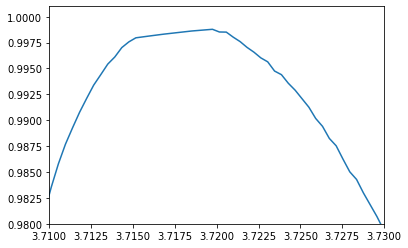

In [881]:

#'Wavelength','Spectra','Filter'

plt.plot(test01['Wavelength'],test01['Spectra'])
#plt.plot(test01['Wavelength'],test01['Filter'],'b')

plt.xlim(3.71,3.73)
plt.ylim(0.98,1.001)
plt.show()
